<div class="usecase-title">Biodiversity Corridors Creation in Melbourne</div>


<div class="usecase-authors"><b>Authored by:</b> Jnaneshwari Beerappa</div>


<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level:</b> Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills:</b> Python, Spatial Analysis, Pandas, Requests, Data Visualization</div>
</div>


<div class="usecase-section-header">Scenarios</div>

<b>Scenario 1: Connecting Isolated Green Spaces</b>  
In inner Melbourne, there are many small green spaces that aren't connected. This limits the movement of birds, insects, and other wildlife. By identifying laneways with high greening potential, we can connect these patches to create continuous green corridors that support urban biodiversity.

<b>Scenario 2: Greening in Densely Built-Up Areas</b>  
Some areas have very limited green space due to high-density development. This project helps find underutilised laneways that can be turned into green zones. This adds greenery where large parks aren't possible, benefiting both nature and local communities.

<b>Scenario 3: Supporting Pollinators and Urban Wildlife</b>  
Bees, butterflies, and small mammals need connected green routes to survive in cities. By greening laneways with the right plants, we can create safe pathways for them. This supports pollination and keeps the urban ecosystem healthy.

<b>Scenario 4: Aligning with Tree Planting Schedules</b>  
The Council already has a schedule for planting trees across Melbourne. This project matches potential laneways with planned planting zones, ensuring that resources are used efficiently and greening efforts are coordinated and impactful.


As an urban environmental planner, I want to identify laneways across Melbourne with high greening potential so that I can design biodiversity corridors that connect existing green spaces and enhance urban biodiversity and community well-being.


At the end of this use case you will:
- Learn how to access and work with open datasets using APIs
- Conduct spatial analysis to identify green potential
- Merge ecological and urban datasets to support decision-making
- Visualize spatial data and potential biodiversity corridors in Python


Urban biodiversity is essential for ecological balance, human well-being, and climate resilience. Melbourne is home to a rich array of green spaces, but many are fragmented. This project aims to bridge these gaps by identifying laneways with high greening potential and aligning them with the city's tree planting schedules. Two key datasets used in this analysis are:

- Laneways with Greening Potential: Contains spatial data on laneways assessed for possible greening interventions.
- Tree Planting Zone Schedules: Provides information on planned urban forest activities across various zones.

By overlaying these datasets, we aim to map out biodiversity corridors—continuous strips of vegetation that can serve as habitats and movement paths for urban wildlife.


<div class="usecase-section-header">Learning Objectives</div>

• Understand how spatial data can be used to support real-world environmental and planning decisions.  
• Gain hands-on experience using geospatial libraries such as GeoPandas, Folium, and Shapely for data cleaning, joining, and visualisation.  
• Learn how to identify, filter, and prioritise laneways based on ecological and spatial criteria using real open datasets.  
• Build an interactive map to communicate insights effectively with both technical and non-technical stakeholders.  
• Improve problem-solving skills by handling limitations in open data and adjusting the workflow accordingly.  
• Learn to contribute reusable and documented code to a shared GitHub repository.  
• Explore how machine learning techniques like classification models can help automate the identification of greening opportunities.


<div class="usecase-section-header">Step 1: Importing and Loading Spatial Datasets</div>

To start my project, I needed three key datasets from the City of Melbourne’s open data portal:  
1. Laneways with Greening Potential
2. Tree Planting Zone Schedules
3. Tree Canopy Coverage (2018)

I used Python along with `pandas`, `geopandas`, and `shapely` to load and prepare this data. Instead of manually downloading the files, I wrote a function to fetch them directly using their dataset IDs and the API. This made the process cleaner and more automated.

Each dataset had a `geo_shape` column that contains the geometry in JSON format. So, I converted that into actual geometric objects using `shapely.shape()`. This step was important because I needed all the data in spatial form (as GeoDataFrames) to later analyse them geographically and perform spatial joins or visualisations.

After loading the datasets, I quickly checked their dimensions to make sure they were loaded correctly.




In [ ]:
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import shape
from io import StringIO

# Base URL and dataset IDs
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_ids = {
    'laneways': 'laneways-with-greening-potential',
    'planting_zones': 'tree-planting-zone-schedules-with-years-urban-forest',
    'canopies': 'tree-canopies-2018-entire-municipal-area-urban-forest'
}

# Function to load and convert dataset to GeoDataFrame
def load_gdf(dataset_id):
    url = f"{base_url}{dataset_id}/exports/csv"
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text), delimiter=';')

    # Parse the geo_shape field as a dictionary if it's a string
    df = df[df['geo_shape'].notna()]
    df['geometry'] = df['geo_shape'].apply(lambda x: shape(json.loads(x)))

    return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Load all datasets
gdf_laneways = load_gdf(dataset_ids['laneways'])
gdf_planting = load_gdf(dataset_ids['planting_zones'])
gdf_canopies = load_gdf(dataset_ids['canopies'])

# Check
print("Laneways:", gdf_laneways.shape)
print("Planting Zones:", gdf_planting.shape)
print("Canopies:", gdf_canopies.shape)


Laneways: (246, 24)
Planting Zones: (839, 13)
Canopies: (54680, 6)


<div class="usecase-section-header">Step 3: Buffering Tree Canopies and Selecting Nearby Laneways</div>

After identifying the high-potential laneways (where `fores_rank == 1`), I wanted to find out which of these laneways are located near existing tree canopy areas. The idea is to give priority to laneways that are close to existing vegetation, so they can act as extensions or connectors to form continuous biodiversity corridors.

To do this, I created a **buffer** around the tree canopy geometries. I used a 5-meter buffer to simulate a zone of influence around each canopy area. This means I’m considering laneways that fall within 5 meters of a tree canopy as having stronger potential for connection.



In [ ]:
high_potential_laneways = gdf_laneways[gdf_laneways['fores_rank'] == 1]
canopy_buffer = gdf_canopies.copy()
canopy_buffer['geometry'] = canopy_buffer.geometry.buffer(5)  # buffer 5 meters



<ipython-input-5-c597fd5960ae>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  canopy_buffer['geometry'] = canopy_buffer.geometry.buffer(5)  # buffer 5 meters


<div class="usecase-section-header">Step 4: Spatial Join to Identify Connected Laneways</div>

After buffering the canopy areas, I wanted to find out which of the high-potential laneways are actually **spatially connected** to these tree canopies. This step is important because it helps me identify laneways that are not just suitable on paper, but also well-positioned geographically to contribute to biodiversity corridors.

To do this, I used a spatial join with the `geopandas.sjoin()` function. The join checks which laneways intersect with the buffered canopy areas. I used an `inner` join and the `intersects` predicate so that I only keep laneways that fall within the 5-meter buffer zone.



In [ ]:
laneways_connected = gpd.sjoin(high_potential_laneways, canopy_buffer, how='inner', predicate='intersects')

# Checking how many laneways are connected to canopy zones
print("Connected Laneways:", laneways_connected.shape)


Connected Laneways: (0, 30)


<div class="usecase-section-header">Step 5: Visualising Biodiversity Corridors on an Interactive Map</div>

To bring the analysis to life, I visualised the spatial data on an interactive map using Folium. This helped me better understand the relationship between laneways, tree canopy coverage, and planned tree planting zones.

For performance, I used samples of the canopy and planting zone datasets, and visualised all high-potential laneways. Each layer has a different color and popup for context:
- Tree Canopies are shown in green with popup areas
- Planting Zones are orange with street names and planting schedules
- Laneways are blue, showing their greening type or name

This step is really useful for visually identifying which laneways are connected to existing greenery and align with tree planting schedules. It also makes it easy to share insights with stakeholders like urban planners or environmental groups.




<div class="usecase-section-header">Step 6: Spatially Linking Laneways with Tree Canopies and Planting Zones</div>

To strengthen my analysis, I made sure all the spatial datasets were in the same Coordinate Reference System (CRS). This is important for accurate spatial joins. I used EPSG:4326 (WGS84), which is standard for mapping and web-based visualizations.

After ensuring CRS alignment, I continued with the laneways that were previously filtered as high-potential based on their `fores_rank`. My goal here was to see which of these laneways intersect with either tree canopies or tree planting zones — meaning they are not only ecologically promising but also well-situated in space.

I performed two spatial joins:
- The first join matched high-potential laneways with tree canopy areas, helping identify existing natural coverage.
- The second join matched **high-potential laneways with scheduled tree planting zones, showing where greening is already planned.

These spatial matches helped highlight laneways that are strategically positioned for extending biodiversity corridors, either by connecting to existing canopy cover or aligning with future tree planting efforts.



In [ ]:
import geopandas as gpd

# Ensure all GeoDataFrames use the same CRS
gdf_canopies = gdf_canopies.to_crs(epsg=4326)
gdf_planting = gdf_planting.to_crs(epsg=4326)
gdf_laneways = gdf_laneways.to_crs(epsg=4326)

# Filter laneways with highest foresight rank
laneways_high = gdf_laneways[gdf_laneways['fores_rank'] == 1]

# Join laneways with tree canopy data
laneways_canopy_intersections = gpd.sjoin(laneways_high, gdf_canopies, how="inner", predicate='intersects')

# Join laneways with planting zones
laneways_planting_intersections = gpd.sjoin(laneways_high, gdf_planting, how="inner", predicate='intersects')


<div class="usecase-section-header">Step 7: Exploring Intersections for Feature Selection</div>

Before moving into prediction or scoring, I wanted to take a closer look at the structure of the two newly created datasets:
- `laneways_canopy_intersections`
- `laneways_planting_intersections`

These datasets were created using spatial joins in the previous step and contain important information about which laneways intersect with existing tree canopies and upcoming tree planting zones.

By printing the column names, I can identify:
- Which features were retained from the original laneway dataset
- Which new columns were brought in from the canopy or planting datasets
- What additional attributes (like `schedule`, `shape_area`, or `streetname`) I can use later in the AI model or scoring system




In [ ]:
print("Canopy intersection columns:")
print(laneways_canopy_intersections.columns.tolist())

print("\nPlanting zone intersection columns:")
print(laneways_planting_intersections.columns.tolist())


Canopy intersection columns:
['geo_point_2d_left', 'geo_shape_left', 'segid_1', 'mapbase_mc', 'insol_scor', 'verticalsu', 'segid', 'driveways', 'parklane', 'objectid_left', 'climate_ty', 'narrowing', 'closepart', 'farmlane', 'walls', 'farm_rank', 'vert_rank', 'fores_rank', 'forest', 'park_rank', 'binsperct', 'mapbase_1', 'wsud', 'geometry', 'index_right', 'geo_point_2d_right', 'geo_shape_right', 'objectid_right', 'shape_leng', 'shape_area']

Planting zone intersection columns:
['geo_point_2d_left', 'geo_shape_left', 'segid_1', 'mapbase_mc', 'insol_scor', 'verticalsu', 'segid_left', 'driveways', 'parklane', 'objectid', 'climate_ty', 'narrowing', 'closepart', 'farmlane', 'walls', 'farm_rank', 'vert_rank', 'fores_rank', 'forest', 'park_rank', 'binsperct', 'mapbase_1', 'wsud', 'geometry', 'index_right', 'geo_point_2d_right', 'geo_shape_right', 'str_from', 'segpart', 'statusid', 'segid_right', 'streetname', 'streetid', 'schedule', 'mapstatus', 'str_to', 'segdescr']


In [ ]:
print(gdf_laneways.columns.tolist())


['geo_point_2d', 'geo_shape', 'segid_1', 'mapbase_mc', 'insol_scor', 'verticalsu', 'segid', 'driveways', 'parklane', 'objectid', 'climate_ty', 'narrowing', 'closepart', 'farmlane', 'walls', 'farm_rank', 'vert_rank', 'fores_rank', 'forest', 'park_rank', 'binsperct', 'mapbase_1', 'wsud', 'geometry']


In [ ]:
print("Canopy columns:", laneways_canopy_intersections.columns.tolist())
print("Planting columns:", laneways_planting_intersections.columns.tolist())


Canopy columns: ['geo_point_2d_left', 'geo_shape_left', 'segid_1', 'mapbase_mc', 'insol_scor', 'verticalsu', 'segid', 'driveways', 'parklane', 'objectid_left', 'climate_ty', 'narrowing', 'closepart', 'farmlane', 'walls', 'farm_rank', 'vert_rank', 'fores_rank', 'forest', 'park_rank', 'binsperct', 'mapbase_1', 'wsud', 'geometry', 'index_right', 'geo_point_2d_right', 'geo_shape_right', 'objectid_right', 'shape_leng', 'shape_area']
Planting columns: ['geo_point_2d_left', 'geo_shape_left', 'segid_1', 'mapbase_mc', 'insol_scor', 'verticalsu', 'segid_left', 'driveways', 'parklane', 'objectid', 'climate_ty', 'narrowing', 'closepart', 'farmlane', 'walls', 'farm_rank', 'vert_rank', 'fores_rank', 'forest', 'park_rank', 'binsperct', 'mapbase_1', 'wsud', 'geometry', 'index_right', 'geo_point_2d_right', 'geo_shape_right', 'str_from', 'segpart', 'statusid', 'segid_right', 'streetname', 'streetid', 'schedule', 'mapstatus', 'str_to', 'segdescr']


In [ ]:
import pandas as pd
import geopandas as gpd
import requests, json
from shapely.geometry import shape
from io import StringIO

# Step 1: Load spatial datasets from API
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_ids = {
    'laneways': 'laneways-with-greening-potential',
    'planting_zones': 'tree-planting-zone-schedules-with-years-urban-forest',
    'canopies': 'tree-canopies-2018-entire-municipal-area-urban-forest'
}

def load_gdf(dataset_id):
    url = f"{base_url}{dataset_id}/exports/csv"
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text), delimiter=';')
    df = df[df['geo_shape'].notna()]  # Remove rows with no geometry
    df['geometry'] = df['geo_shape'].apply(lambda x: shape(json.loads(x)))
    return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

gdf_laneways = load_gdf(dataset_ids['laneways'])
gdf_planting = load_gdf(dataset_ids['planting_zones'])
gdf_canopies = load_gdf(dataset_ids['canopies'])

# Step 2: Reproject to a projected CRS (for accurate spatial operations)
projected_crs = "EPSG:3857"
gdf_laneways = gdf_laneways.to_crs(projected_crs)
gdf_planting = gdf_planting.to_crs(projected_crs)
gdf_canopies = gdf_canopies.to_crs(projected_crs)

# Step 3: Create a 5m buffer around canopies to simulate their influence zone
canopy_buffer = gdf_canopies.copy()
canopy_buffer['geometry'] = canopy_buffer.geometry.buffer(5)

# Step 4: Spatial joins to find intersecting laneways
laneways_canopy_intersections = gpd.sjoin(gdf_laneways, canopy_buffer, how='inner', predicate='intersects')
laneways_planting_intersections = gpd.sjoin(gdf_laneways, gdf_planting, how='inner', predicate='intersects')

# Step 5: Check overlaps (print counts)
print("Laneways intersecting with tree canopies:", laneways_canopy_intersections.shape[0])
print("Laneways intersecting with planting zones:", laneways_planting_intersections.shape[0])


Laneways intersecting with tree canopies: 261
Laneways intersecting with planting zones: 123


In [ ]:
import pandas as pd

# Step 1: Use correct column names
canopy_lanes = laneways_canopy_intersections[['segid']].drop_duplicates()
planting_lanes = laneways_planting_intersections[['segid_left']].rename(columns={'segid_left': 'segid'}).drop_duplicates()

# Step 2: Combine both sets
all_matched_ids = pd.concat([canopy_lanes, planting_lanes]).drop_duplicates()

# Step 3: Merge with original laneways to bring back scoring columns
matched_laneways = gdf_laneways.merge(all_matched_ids, on='segid', how='inner')

# Step 4: Check your progress
print("Total matched laneways after combining intersections:", matched_laneways.shape)


Total matched laneways after combining intersections: (167, 24)


In [ ]:
# Combine unique segment IDs from both spatial joins
canopy_ids = laneways_canopy_intersections['segid'].dropna().unique()
planting_ids = laneways_planting_intersections['segid_left'].dropna().unique()

# Combine and deduplicate
combined_ids = pd.Series(list(set(canopy_ids) | set(planting_ids)))

# Merge with original laneways dataset
matched_laneways = gdf_laneways[gdf_laneways['segid'].isin(combined_ids)]

# Now check
print("New matched laneways rows:", matched_laneways.shape)


New matched laneways rows: (167, 24)


In [ ]:
print("Unique fores_rank values:", matched_laneways['fores_rank'].unique())
print("Unique insol_scor values:", matched_laneways['insol_scor'].unique())
print("Number of rows with at least one valid score:",
      matched_laneways[['fores_rank', 'insol_scor']].dropna(how='all').shape[0])


Unique fores_rank values: ['Good potential' 'Lowest potential' 'Highest potential' 'Some potential']
Unique insol_scor values: [3.110616 2.269407 1.731598 2.754746 2.23413  1.69227  1.789866 2.067394
 2.888133 2.911745 2.81157  2.125395 2.704321 2.567765 2.029585 2.327876
 2.477814 2.831451 2.965487 2.06344  2.367461 2.135954 1.709022 3.01853
 2.122155 2.238165 2.807233 2.584059 2.570831 2.241196 1.796544 1.515332
 2.557044 2.31714  2.611334 1.598355 1.430429 2.348098 2.014619 5.349117
 2.88918  2.703381 1.120387 3.128363 4.422277 4.291275 2.943436 1.584558
 1.433145 2.76759  2.713662 2.01965  3.216198 2.924579 4.729036 3.156374
 7.681368 6.492595 2.215613 2.750935 1.612879 2.274434 2.729962 1.431186
 1.783985 1.671871 1.470082 2.294066 3.474666 3.324952 2.442442 2.882335
 2.313231 2.57187  1.811053 5.749005 1.252588 2.935355 1.725799 2.500188
 1.969904 2.991574 1.339244 1.410364 3.364412 2.684087 2.735157 1.533126
 2.217595 1.429548 2.888811 3.5747   2.497896 2.044473 1.65005  2.74377

In [ ]:
for col in ['fores_rank', 'vert_rank', 'insol_scor', 'park_rank']:
    print(f"{col} - Unique values:", gdf_laneways[col].unique())
print("Rows with any valid scores in original laneway data:",
      gdf_laneways[['fores_rank', 'vert_rank', 'insol_scor', 'park_rank']].dropna(how='all').shape[0])


fores_rank - Unique values: ['Lowest potential' 'Good potential' 'Highest potential' 'Some potential']
vert_rank - Unique values: ['Highest potential' 'Good potential' 'Lowest potential' 'Some potential']
insol_scor - Unique values: [4.056745 3.110616 2.269407 1.731598 2.754746 2.23413  2.427456 1.69227
 1.789866 2.067394 1.216029 2.888133 1.854101 1.550607 2.911745 2.81157
 1.850267 2.125395 2.704321 2.567765 3.725437 2.722788 2.2266   3.215227
 2.029585 3.641199 1.524454 1.789136 1.887674 1.954132 2.576063 2.327876
 2.477814 2.831451 2.965487 2.06344  2.367461 2.135954 1.709022 3.01853
 2.122155 2.088217 2.238165 2.807233 2.584059 2.570831 2.241196 1.095631
 1.461997 1.926661 1.796544 1.515332 2.557044 2.31714  2.611334 1.598355
 1.430429 2.348098 2.014619 5.349117 2.88918  2.703381 1.120387 3.128363
 4.422277 4.291275 2.851537 2.943436 1.584558 1.433145 2.76759  1.183589
 2.713662 2.01965  3.216198 2.924579 4.729036 2.484323 3.156374 3.538454
 7.681368 6.492595 2.215613 2.750935 1.6

In [ ]:
# See which columns include our keywords
print("Columns that match keywords:\n")
for col in gdf_laneways.columns:
    if any(key in col for key in ['fores', 'vert', 'insol', 'park']):
        print(col)
# Check first few rows
gdf_laneways[['fores_rank', 'vert_rank', 'insol_scor', 'park_rank']].head(10)


Columns that match keywords:

insol_scor
verticalsu
parklane
vert_rank
fores_rank
forest
park_rank


,fores_rank,vert_rank,insol_scor,park_rank
0,Lowest potential,Highest potential,4.056745,Highest potential
1,Good potential,Good potential,3.110616,Lowest potential
2,Lowest potential,Highest potential,2.269407,Good potential
3,Highest potential,Highest potential,1.731598,Lowest potential
4,Lowest potential,Highest potential,2.754746,Highest potential
5,Good potential,Good potential,2.234130,Lowest potential
6,Lowest potential,Good potential,2.427456,Highest potential
7,Highest potential,Highest potential,1.692270,Lowest potential
8,Lowest potential,Lowest potential,1.789866,Good potential
9,Lowest potential,Highest potential,2.067394,Lowest potential


In [ ]:
gdf_laneways[['fores_rank', 'vert_rank', 'insol_scor', 'park_rank']].head(10)


,fores_rank,vert_rank,insol_scor,park_rank
0,Lowest potential,Highest potential,4.056745,Highest potential
1,Good potential,Good potential,3.110616,Lowest potential
2,Lowest potential,Highest potential,2.269407,Good potential
3,Highest potential,Highest potential,1.731598,Lowest potential
4,Lowest potential,Highest potential,2.754746,Highest potential
5,Good potential,Good potential,2.234130,Lowest potential
6,Lowest potential,Good potential,2.427456,Highest potential
7,Highest potential,Highest potential,1.692270,Lowest potential
8,Lowest potential,Lowest potential,1.789866,Good potential
9,Lowest potential,Highest potential,2.067394,Lowest potential


In [ ]:
print(gdf_laneways.columns.tolist())


['geo_point_2d', 'geo_shape', 'segid_1', 'mapbase_mc', 'insol_scor', 'verticalsu', 'segid', 'driveways', 'parklane', 'objectid', 'climate_ty', 'narrowing', 'closepart', 'farmlane', 'walls', 'farm_rank', 'vert_rank', 'fores_rank', 'forest', 'park_rank', 'binsperct', 'mapbase_1', 'wsud', 'geometry']


In [ ]:
for col in gdf_laneways.columns:
    non_null_count = gdf_laneways[col].notna().sum()
    if non_null_count > 0:
        print(f"{col}: {non_null_count} non-null values")


geo_point_2d: 246 non-null values
geo_shape: 246 non-null values
segid_1: 246 non-null values
mapbase_mc: 246 non-null values
insol_scor: 246 non-null values
verticalsu: 246 non-null values
segid: 246 non-null values
driveways: 246 non-null values
parklane: 246 non-null values
objectid: 246 non-null values
climate_ty: 246 non-null values
narrowing: 246 non-null values
closepart: 246 non-null values
farmlane: 246 non-null values
walls: 246 non-null values
farm_rank: 246 non-null values
vert_rank: 246 non-null values
fores_rank: 246 non-null values
forest: 246 non-null values
park_rank: 246 non-null values
binsperct: 246 non-null values
mapbase_1: 243 non-null values
wsud: 246 non-null values
geometry: 246 non-null values


In [ ]:
gdf_laneways.head(5)


,geo_point_2d,geo_shape,segid_1,mapbase_mc,insol_scor,verticalsu,segid,driveways,parklane,objectid,...,walls,farm_rank,vert_rank,fores_rank,forest,park_rank,binsperct,mapbase_1,wsud,geometry
0,"-37.81535672343349, 144.95569265063773","{""coordinates"": [[[[144.9556606568115, -37.815...",20061,0.0,4.056745,66.713100,20061,0,63.516600,0,...,Consider,Lowest potential,Highest potential,Lowest potential,0.000000,Highest potential,0.0,Bourke Place,Probably Unsuitable,"MULTIPOLYGON (((16136390.332 -4553373.298, 161..."
1,"-37.81037958674067, 144.97089952599487","{""coordinates"": [[[[144.9708657242154, -37.810...",20226,20226.0,3.110616,48.868240,20226,5 or more,0.000000,2,...,Consider,Lowest potential,Good potential,Good potential,38.521944,Lowest potential,40.0,Punch Lane,Consider,"MULTIPOLYGON (((16138082.952 -4552640.409, 161..."
2,"-37.810217121848865, 144.97162762401734","{""coordinates"": [[[[144.9717580200683, -37.810...",20227,20227.0,2.269407,57.564357,20227,2,48.897065,3,...,Consider,Lowest potential,Highest potential,Lowest potential,0.000000,Good potential,40.0,Little Bourke Place,Consider,"MULTIPOLYGON (((16138182.282 -4552699.294, 161..."
3,"-37.81077581774339, 144.97188375120993","{""coordinates"": [[[[144.97184322645086, -37.81...",20228,20228.0,1.731598,63.224829,20228,1,0.000000,4,...,Consider,Lowest potential,Highest potential,Highest potential,55.532329,Lowest potential,40.0,Cl1639,Consider,"MULTIPOLYGON (((16138191.767 -4552709.666, 161..."
4,"-37.811226042417026, 144.97139352262127","{""coordinates"": [[[[144.9716104991305, -37.811...",20231,20231.0,2.754746,67.186286,20231,1,65.118885,7,...,Consider,Lowest potential,Highest potential,Lowest potential,0.000000,Highest potential,40.0,Liverpool Street,Consider,"MULTIPOLYGON (((16138165.86 -4552849.108, 1613..."


In [ ]:
gdf_laneways = load_gdf(dataset_ids['laneways'])
print("Laneways shape:", gdf_laneways.shape)
gdf_laneways.head(3)


Laneways shape: (246, 24)


,geo_point_2d,geo_shape,segid_1,mapbase_mc,insol_scor,verticalsu,segid,driveways,parklane,objectid,...,walls,farm_rank,vert_rank,fores_rank,forest,park_rank,binsperct,mapbase_1,wsud,geometry
0,"-37.81535672343349, 144.95569265063773","{""coordinates"": [[[[144.9556606568115, -37.815...",20061,0.0,4.056745,66.713100,20061,0,63.516600,0,...,Consider,Lowest potential,Highest potential,Lowest potential,0.000000,Highest potential,0.0,Bourke Place,Probably Unsuitable,"MULTIPOLYGON (((144.95566 -37.81535, 144.95571..."
1,"-37.81037958674067, 144.97089952599487","{""coordinates"": [[[[144.9708657242154, -37.810...",20226,20226.0,3.110616,48.868240,20226,5 or more,0.000000,2,...,Consider,Lowest potential,Good potential,Good potential,38.521944,Lowest potential,40.0,Punch Lane,Consider,"MULTIPOLYGON (((144.97087 -37.81015, 144.97115..."
2,"-37.810217121848865, 144.97162762401734","{""coordinates"": [[[[144.9717580200683, -37.810...",20227,20227.0,2.269407,57.564357,20227,2,48.897065,3,...,Consider,Lowest potential,Highest potential,Lowest potential,0.000000,Good potential,40.0,Little Bourke Place,Consider,"MULTIPOLYGON (((144.97176 -37.81056, 144.97147..."


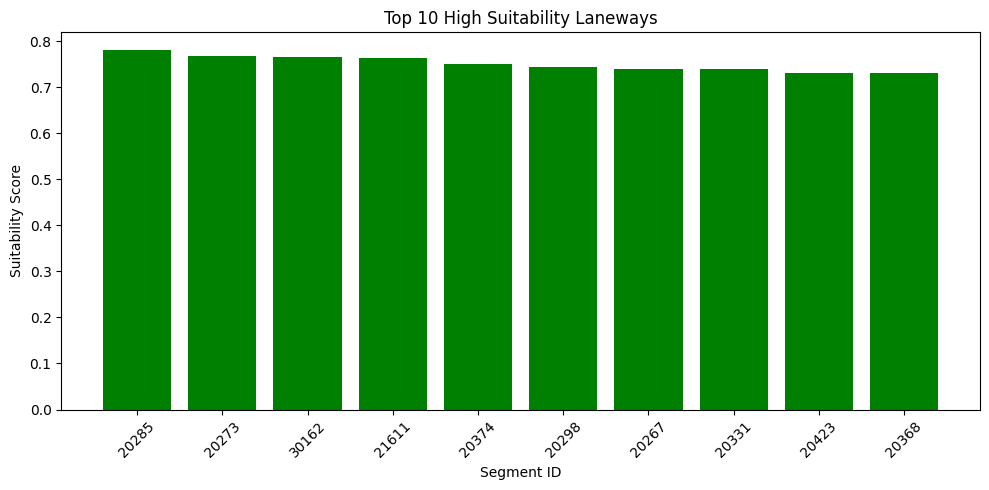

,segid,suitability_score
20,20285,0.779936
93,20273,0.767781
74,30162,0.764481
151,21611,0.763674
122,20374,0.749881
188,20298,0.742646
178,20267,0.739466
198,20331,0.738844
138,20423,0.730406
41,20368,0.730246


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Define the mapping from text to numeric values
rank_map = {
    'Lowest potential': 1,
    'Some potential': 2,
    'Good potential': 3,
    'Highest potential': 4
}

# Step 2: Map rank columns to numeric
for col in ['fores_rank', 'vert_rank', 'park_rank']:
    gdf_laneways[col] = gdf_laneways[col].map(rank_map)

# Convert insol_scor to numeric if not already
gdf_laneways['insol_scor'] = pd.to_numeric(gdf_laneways['insol_scor'], errors='coerce')

# Step 3: Drop missing values
scoring_columns = ['fores_rank', 'vert_rank', 'insol_scor', 'park_rank']
gdf_laneways = gdf_laneways.dropna(subset=scoring_columns)

# Step 4: Normalize values using MinMaxScaler
scaler = MinMaxScaler()
gdf_laneways[scoring_columns] = scaler.fit_transform(gdf_laneways[scoring_columns])

# Step 5: Assign weights and calculate suitability score
weights = {
    'fores_rank': 0.4,
    'vert_rank': 0.3,
    'insol_scor': 0.2,
    'park_rank': 0.1
}

gdf_laneways['suitability_score'] = (
    weights['fores_rank'] * gdf_laneways['fores_rank'] +
    weights['vert_rank'] * gdf_laneways['vert_rank'] +
    weights['insol_scor'] * gdf_laneways['insol_scor'] +
    weights['park_rank'] * gdf_laneways['park_rank']
)

# Step 6: Get top 10 laneways
top_10 = gdf_laneways.sort_values(by='suitability_score', ascending=False).head(10)

# Step 7: Visualize
plt.figure(figsize=(10, 5))
plt.bar(top_10['segid'].astype(str), top_10['suitability_score'], color='green')
plt.xlabel('Segment ID')
plt.ylabel('Suitability Score')
plt.title('Top 10 High Suitability Laneways')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display top 10 table
top_10[['segid', 'suitability_score']]


In [ ]:
import folium
from folium import GeoJson
from shapely.geometry import mapping

# Center on Melbourne
melbourne_coords = [-37.8136, 144.9631]
m = folium.Map(location=melbourne_coords, zoom_start=13)

# Add top 10 laneways as GeoJSON
for _, row in top_10.iterrows():
    geom = mapping(row['geometry'])
    folium.GeoJson(
        geom,
        name=f"Laneway {row['segid']}",
        tooltip=f"Segment ID: {row['segid']}<br>Score: {row['suitability_score']:.2f}"
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display map
m
